In [14]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [5]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

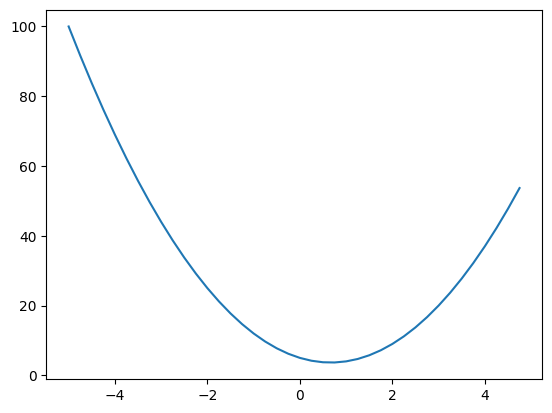

In [6]:
plt.plot(xs, ys)

## Derivative

In [20]:
h = 0.000000001
x = 2/3
dx = (f(x+h) - f(x))/h
dx

0.0

## Particial derivatives

In [21]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


#### dx/da

In [22]:
h = 0.0000000001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
a += h
d2 = a*b + c

print("d1 :",d1)
print("d2 :",d2)
print("slope (dx/da):", ((d2-d1)/h))

d1 : 4.0
d2 : 3.9999999997
slope (dx/da): -3.000000248221113


#### dx/db

In [23]:
h = 0.0000000001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
b += h
d2 = a*b + c

print("d1 :",d1)
print("d2 :",d2)
print("slope (dx/db):", ((d2-d1)/h))

d1 : 4.0
d2 : 4.0000000002
slope (dx/db): 2.000000165480742


#### dx/dc

In [24]:
h = 0.0000000001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
c += h
d2 = a*b + c

print("d1 :",d1)
print("d2 :",d2)
print("slope (dx/dc):", ((d2-d1)/h))

d1 : 4.0
d2 : 4.0000000001
slope (dx/dc): 1.000000082740371


## data structure : value object

In [7]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,  other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,  other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out  
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting integer/float power for now"
        out = Value(self.data**other, (self, ), f"**{other}")
        
        def _backward():
            self.grad += (other* (self.data ** (other -1))) * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self*(-1)
    
    def __sub__(self, other):
        return self + (-other)
    
    def __truediv__(self, other):
        return self * (other**-1)
    
    def tanh(self):
        x = self.data 
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1.0 - t**2 )* out.grad
            
        out._backward = _backward 
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)   
                topo.append(v)
                
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [274]:
# (a.__mul__(b)).__add__(c) --> a*b + c

### forward propagation example

In [113]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f; g.label = 'L'
L

Value(data=-8.0)

In [114]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [115]:
d._op

'+'

In [10]:
!pip install graphviz

  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)


### visualize

In [11]:
from graphviz import Digraph

def trace(root):
    """
    Build a set of all nodes and edges in the graph
    """
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_graph(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR --> left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape ='record')
        
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot
        

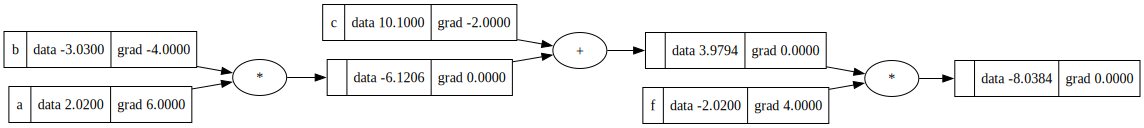

In [215]:
draw_graph(L)

In [216]:
a.data += 0.01 * a.data
b.data += 0.01 * b.data
c.data += 0.01 * c.data
f.data += 0.01 * f.data

e = a*b
d = e + c
L = d * f



In [129]:
print(L.data)

-8.038388


In [130]:
def comp():
    h = 0.001
    
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; g.label = 'L'
    L1 = L.data
    
    a = Value(2.0 , label = 'a')
    b = Value(-3.0 + h , label = 'b')
    c = Value(10.0 , label = 'c')
    e = a*b; e.label = 'e'
    d = e + c ; d.label = 'd'
    f = Value(-2.0 , label = 'f')
    L = d * f; g.label = 'L'
    L2 = L.data 
    
    return ((L2 - L1)/h)

In [131]:
comp()

-3.9999999999995595

### neuron

In [266]:
# inputs x1,  x2 of the neuron
x1 = Value(2.0 , label = 'x1')
x2 = Value(0.0 , label = 'x2')

# weights w1, w2 of the neuron
w1 = Value(-3.0 , label = 'w1')
w2 = Value(1.0 , label = 'w2')

# bias of the neuron
b = Value(6.8813735870195432 , label = 'b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
out = n.tanh(); out.label = 'out'
out.backward()

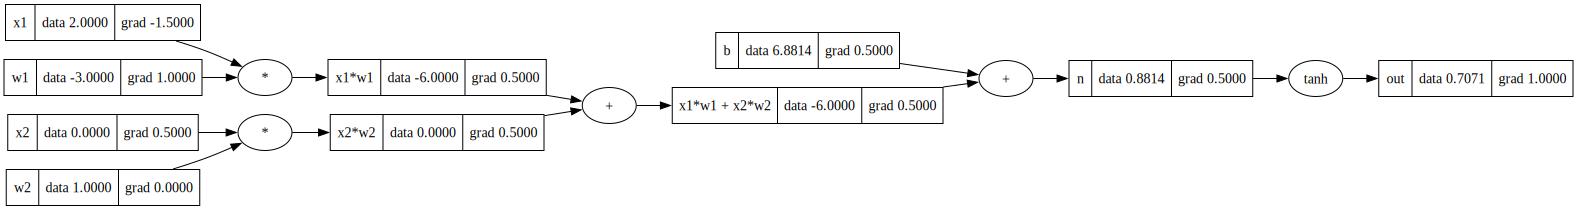

In [267]:
draw_graph(out)

In [275]:
# inputs x1,  x2 of the neuron
x1 = Value(2.0 , label = 'x1')
x2 = Value(0.0 , label = 'x2')

# weights w1, w2 of the neuron
w1 = Value(-3.0 , label = 'w1')
w2 = Value(1.0 , label = 'w2')

# bias of the neuron
b = Value(6.8813735870195432 , label = 'b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# --------
e = (2*n).exp()
out1 = (e-1)/(e+1)
out1.label = 'out'
# -------- 
out1.backward()

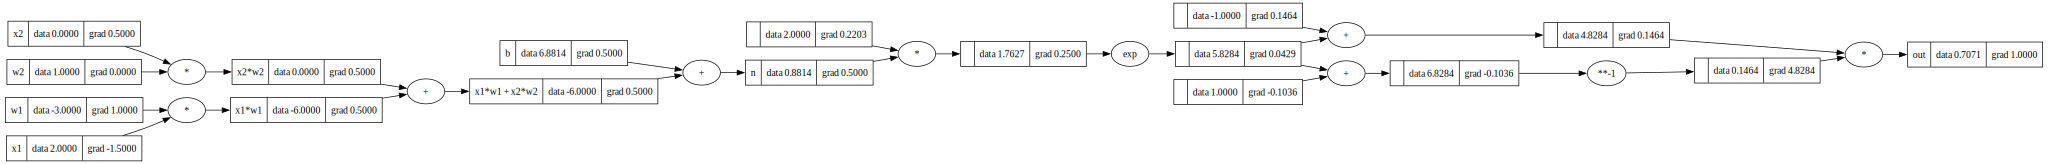

In [276]:
draw_graph(out1)

### PyTorch

In [3]:
import torch
x1 = torch.Tensor([2.0]).double()  ;  x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()  ;  x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ;  w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()  ;  w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
out = torch.tanh(n)

print(out.data.item())
out.backward()

print("---------")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7071066904050358
---------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


### Neural Network

In [12]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) 
        out = activation.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        parameters = []
        for neuron in self.neurons:
            params = neuron.parameters()
            parameters.extend(params)
        return parameters
        
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x 
    
    def parameters(self):
        parameters = []
        for layer in self.layers:
            params = layer.parameters()
            parameters.extend(params)
        return parameters

In [15]:
x = [1.0, 2.0, -5.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.4287725313473688)

In [426]:
n.parameters()

[Value(data=-0.8264434048410971),
 Value(data=-0.46061087314296456),
 Value(data=0.9774444939376536),
 Value(data=0.2767437420996326),
 Value(data=-0.2438663868323372),
 Value(data=0.2619275177878666),
 Value(data=0.9555868728559433),
 Value(data=-0.5424833370189217),
 Value(data=-0.6158109190181971),
 Value(data=-0.40152561937317865),
 Value(data=0.822306341652081),
 Value(data=-0.5789016986629969),
 Value(data=0.30709865773670675),
 Value(data=-0.34346404968331945),
 Value(data=-0.13351368899277682),
 Value(data=-0.6758845197337056),
 Value(data=-0.72583196789317),
 Value(data=-0.8138060403353402),
 Value(data=0.4538158542218813),
 Value(data=0.17421366730493415),
 Value(data=-0.9465563302951436),
 Value(data=-0.820597710041473),
 Value(data=0.387229535443685),
 Value(data=0.176118751474434),
 Value(data=-0.3719826427410222),
 Value(data=-0.5689179552990136),
 Value(data=-0.4937766026187782),
 Value(data=-0.6194930530654124),
 Value(data=-0.2252083336947619),
 Value(data=-0.782756326

In [367]:
x = [2.0, 3.0]
n = Neuron(3)
n(x)

Value(data=0.9318624830296489)

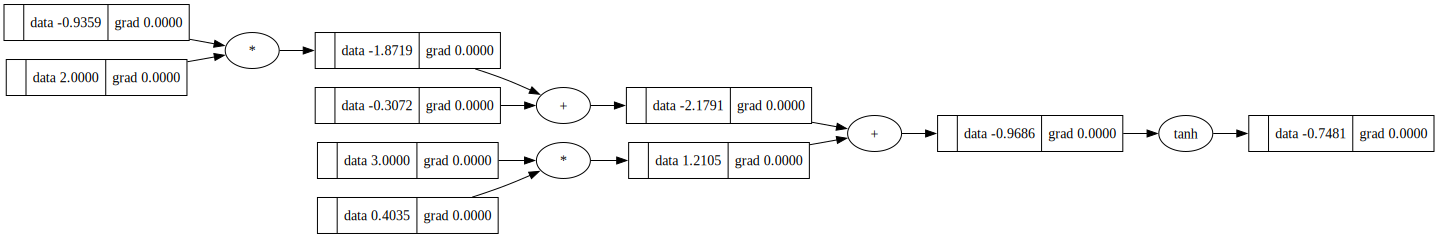

In [364]:
draw_graph(n(x))

In [16]:
x = [4.0, 3.0, -5.0]
n = MLP(3, [4,4,1])
n(x) 

Value(data=0.874456287173675)

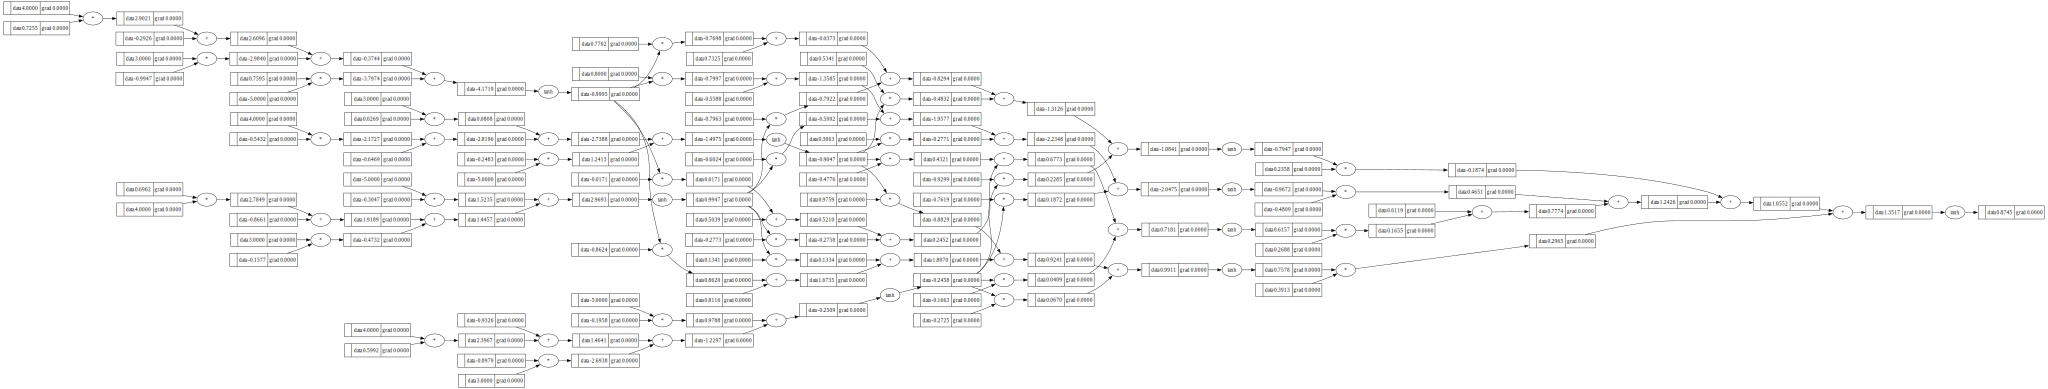

In [18]:
draw_graph(n(x))

In [661]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] 

In [662]:
y_pred = [n(x) for x in xs]
y_pred

[Value(data=0.687922005496942),
 Value(data=0.3753405759995498),
 Value(data=0.7420614757584235),
 Value(data=0.3668271982278009)]

In [429]:
y_pred = [n(x) for x in xs]
loss = sum([(yout-y)**2 for y, yout in zip(ys, y_pred)])
loss

Value(data=4.627371253188954)

In [438]:
loss.backward()

In [435]:
n.layers[0].neurons[0].w[0].grad

0.06854812084796556

In [432]:
n.layers[0].neurons[0].w[0].data

-0.8264434048410971

In [ ]:
draw_graph(loss)

In [19]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [474]:
n.layers[0].neurons[0].w[0].data

-0.4445967053351024

In [665]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] 

In [666]:
for k in range(20):
    # forward pass
    y_pred = [n(x) for x in xs]
    loss = sum([(yout-y)**2 for y, yout in zip(ys, y_pred)])
    
    # zero the gradient
    for p in n.parameters():
        p.grad = 0.0
    
    # backward pass
    loss.backward()
    
    # update parameters
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(f"k : {k} | loss : {loss.data} ")

k : 0 | loss : 0.0020392674834353716 
k : 1 | loss : 0.00193952220811559 
k : 2 | loss : 0.0018490003249002805 
k : 3 | loss : 0.0017664852316769271 
k : 4 | loss : 0.0016909647613985942 
k : 5 | loss : 0.0016215900265215183 
k : 6 | loss : 0.0015576438143209623 
k : 7 | loss : 0.0014985160443414932 
k : 8 | loss : 0.00144368451370311 
k : 9 | loss : 0.0013926996476975298 
k : 10 | loss : 0.0013451723166574463 
k : 11 | loss : 0.0013007640234645127 
k : 12 | loss : 0.00125917894071313 
k : 13 | loss : 0.0012201574033745266 
k : 14 | loss : 0.0011834705559304267 
k : 15 | loss : 0.0011489159220333023 
k : 16 | loss : 0.001116313716500209 
k : 17 | loss : 0.0010855037585637123 
k : 18 | loss : 0.001056342875121805 
k : 19 | loss : 0.0010287027056407837 


In [667]:
y_pred

[Value(data=0.9999982098496456),
 Value(data=-0.9999961940249926),
 Value(data=-0.9679266047194487),
 Value(data=0.9999982313257229)]

In [20]:
n.parameters()

[Value(data=0.7255351770047624),
 Value(data=-0.9946657227461364),
 Value(data=0.7594859799164202),
 Value(data=-0.29256744268333),
 Value(data=0.6962352551380608),
 Value(data=-0.15772400065129344),
 Value(data=-0.30470813404734165),
 Value(data=-0.8660507065082514),
 Value(data=-0.5431785872331814),
 Value(data=0.02692674926192029),
 Value(data=-0.2482595822237934),
 Value(data=-0.6468662275608639),
 Value(data=0.5991813454586994),
 Value(data=-0.8979186161016617),
 Value(data=-0.1957525718660098),
 Value(data=-0.9326222468584922),
 Value(data=-0.01708399473701183),
 Value(data=-0.27725191643835),
 Value(data=-0.4775802365491435),
 Value(data=-0.166307748539394),
 Value(data=0.5039118550583888),
 Value(data=0.8000394431270961),
 Value(data=-0.6023646897875967),
 Value(data=0.3062790754843292),
 Value(data=-0.7619279596694704),
 Value(data=-0.5588459246145099),
 Value(data=0.7701692244521088),
 Value(data=-0.7963389870034243),
 Value(data=0.5340624790727151),
 Value(data=-0.9299132298

## Full model